<a href="https://colab.research.google.com/github/gustavo89587/detection-fidelity-score/blob/main/dfs_scoring_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


In [6]:
# --- DFS v1.0 scoring model ---
# DFS = S * T * B  (all values 0..1)

def dfs_score(S: float, T: float, B: float) -> float:
    for v in (S, T, B):
        if not (0.0 <= v <= 1.0):
            raise ValueError("All inputs must be between 0 and 1.")
    return S * T * B

def band(score: float) -> str:
    if score >= 0.80:
        return "High Trust"
    if score >= 0.60:
        return "Operational"
    if score >= 0.40:
        return "Fragile"
    return "Unreliable"


In [7]:
detections = [
    {"name": "Windows 4688 — Encoded PowerShell", "S": 0.82, "T": 0.60, "B": 0.75},
    {"name": "Linux auditd — curl|sh",            "S": 0.78, "T": 0.62, "B": 0.70},
    {"name": "AWS CloudTrail — IAM key creation", "S": 0.70, "T": 0.85, "B": 0.65},
]

df = pd.DataFrame(detections)
df["DFS"] = df.apply(lambda r: dfs_score(r["S"], r["T"], r["B"]), axis=1)
df["Band"] = df["DFS"].apply(band)

df = df.sort_values("DFS", ascending=False).reset_index(drop=True)
df


,name,S,T,B,DFS,Band
0,AWS CloudTrail — IAM key creation,0.70,0.85,0.65,0.38675,Unreliable
1,Windows 4688 — Encoded PowerShell,0.82,0.60,0.75,0.36900,Unreliable
2,Linux auditd — curl|sh,0.78,0.62,0.70,0.33852,Unreliable


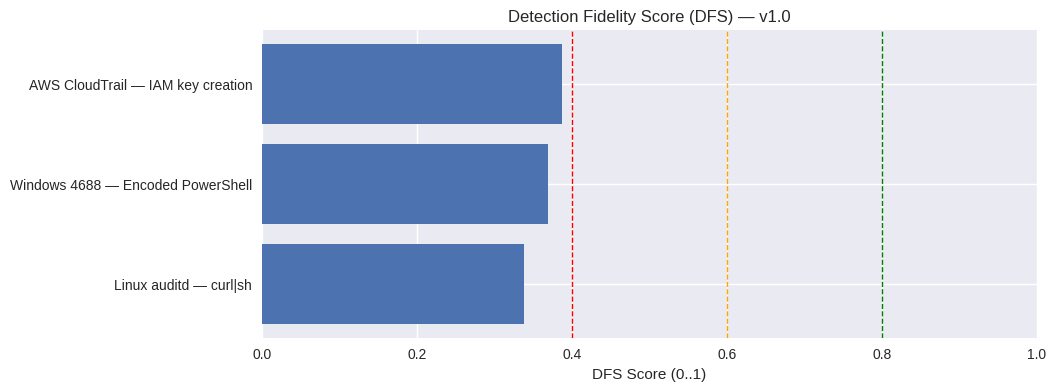

In [8]:
plt.figure(figsize=(10, 4))
plt.barh(df["name"], df["DFS"])
plt.axvline(0.8, color="green", linestyle="--", linewidth=1)
plt.axvline(0.6, color="orange", linestyle="--", linewidth=1)
plt.axvline(0.4, color="red", linestyle="--", linewidth=1)

plt.title("Detection Fidelity Score (DFS) — v1.0")
plt.xlabel("DFS Score (0..1)")
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.show()


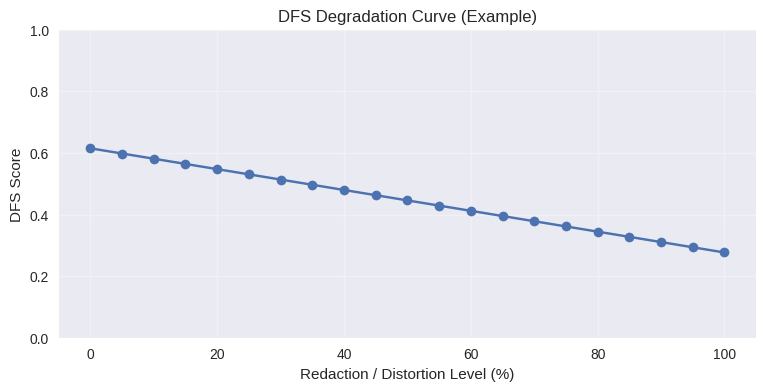

,redaction_%,telemetry_stability,dfs
0,0.0,1.0000,0.615000
1,5.0,0.9725,0.598087
2,10.0,0.9450,0.581175
3,15.0,0.9175,0.564263
4,20.0,0.8900,0.547350


In [9]:
# Keep S and B constant; degrade T as redaction/distortion increases
S = 0.82
B = 0.75

redaction = np.linspace(0, 1, 21)  # 0%..100%

# Simple model: telemetry stability decays as redaction grows
T0 = 1.0
decay = 0.55
T = np.clip(T0 - (decay * redaction), 0, 1)

dfs_vals = S * T * B

plt.figure(figsize=(9, 4))
plt.plot(redaction * 100, dfs_vals, marker="o")
plt.title("DFS Degradation Curve (Example)")
plt.xlabel("Redaction / Distortion Level (%)")
plt.ylabel("DFS Score")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

pd.DataFrame({"redaction_%": redaction*100, "telemetry_stability": T, "dfs": dfs_vals}).head()


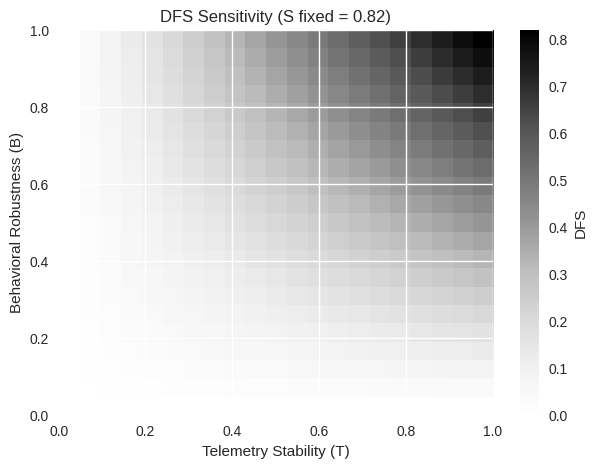

In [10]:
# Fix S, sweep T and B to see where the detection collapses
S_fixed = 0.82
T_grid = np.linspace(0, 1, 21)
B_grid = np.linspace(0, 1, 21)

Z = np.zeros((len(B_grid), len(T_grid)))
for i, Bv in enumerate(B_grid):
    for j, Tv in enumerate(T_grid):
        Z[i, j] = dfs_score(S_fixed, Tv, Bv)

plt.figure(figsize=(7, 5))
plt.imshow(Z, origin="lower", aspect="auto", extent=[0,1,0,1])
plt.colorbar(label="DFS")
plt.title(f"DFS Sensitivity (S fixed = {S_fixed})")
plt.xlabel("Telemetry Stability (T)")
plt.ylabel("Behavioral Robustness (B)")
plt.show()


In [11]:
print("DFS thinking out loud:")
print("- I don't care if the benchmark looks clean.")
print("- I care how fast it collapses when telemetry gets weird.")
print("- If it’s measurable, we can engineer around it.")
print("- If it’s just 'low %', we’re guessing.")


DFS thinking out loud:
- I don't care if the benchmark looks clean.
- I care how fast it collapses when telemetry gets weird.
- If it’s measurable, we can engineer around it.
- If it’s just 'low %', we’re guessing.
